# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [9]:
import numpy as np
import pandas as pd
# import polars as pl
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='oceans16')
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [14]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: потому что возвращает вероятность принадлежности к классу, если переводить в бинарное пространство ответов, то будут те же 0 1 0 1 и тд

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [18]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

In [19]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()
    plt.show()

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


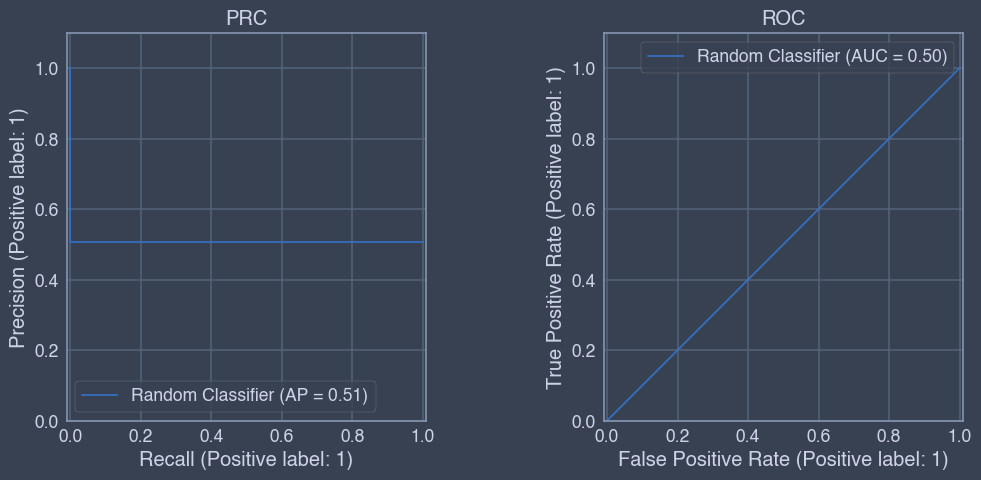

In [20]:
depict_pr_roc(y_test, y_random, 'Random Classifier')

In [21]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [23]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


C_values = np.logspace(-4, 4, 10)

model = LinearSVC()
param_grid = {'C': C_values}
grid = GridSearchCV(model, param_grid, cv = 10, scoring = 'average_precision')
grid.fit(X_train, y_train)

best_C = grid.best_params_['C']
best_cv_score = grid.best_score_
test_accuracy = accuracy_score(y_test, grid.predict(X_test))
print(best_C, best_cv_score, test_accuracy)
y_svm = grid.predict(X_test)
# какая то жопа с данными, почему такие кривые

0.0001 0.8250491032881673 0.7653333333333333


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

In [25]:
df_metrics.loc['SVM_clf'] = [
      average_precision_score(y_test, grid.predict(X_test)),
      roc_auc_score(y_test, grid.predict(X_test)),
      0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
SVM_clf,0.713840,0.765779,0.0


SVM_clf metrics
AUC-PR: 0.7138
AUC-ROC: 0.7658


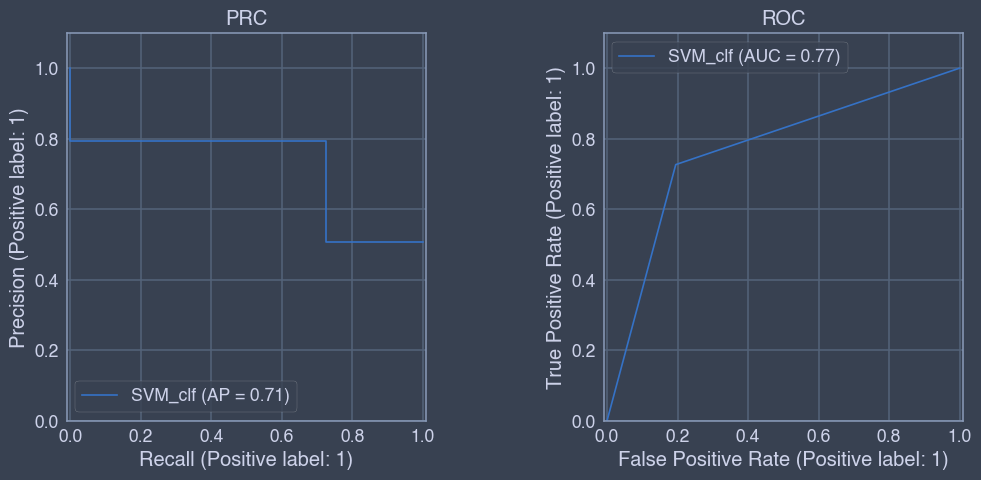

In [26]:
depict_pr_roc(y_test, grid.predict(X_test), 'SVM_clf')

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

не понял, но мы явно можем видеть что свм работает, причем достаточно неплохо, чему я удивлен, а то там данные мега обосранные, почему то генерит другие, чем дано было соколовым 

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [31]:
from sklearn.linear_model import LogisticRegression

C_values = np.logspace(-4, 4, 10)

lr_clf = LogisticRegression(penalty = "l2", max_iter = 1000)
param_grid = {'C': C_values}
grid = GridSearchCV(lr_clf, param_grid, cv = 10, scoring = 'average_precision')
grid.fit(X_train, y_train)

best_C = grid.best_params_['C']
best_cv_score = grid.best_score_
test_accuracy = accuracy_score(y_test, grid.predict(X_test))
print(best_C, best_cv_score, test_accuracy)

y_lr = grid.predict_proba(X_test)[:,1]

df_metrics.loc['LR_clf'] = [
      average_precision_score(y_test, grid.predict(X_test)),
      roc_auc_score(y_test, grid.predict(X_test)),
      0,
]
df_metrics

0.000774263682681127 0.8290626534845806 0.769


,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.0
SVM_clf,0.713840,0.765779,0.0
LR_clf,0.712028,0.769057,0.0


LR_clf metrics
AUC-PR: 0.7120
AUC-ROC: 0.7691


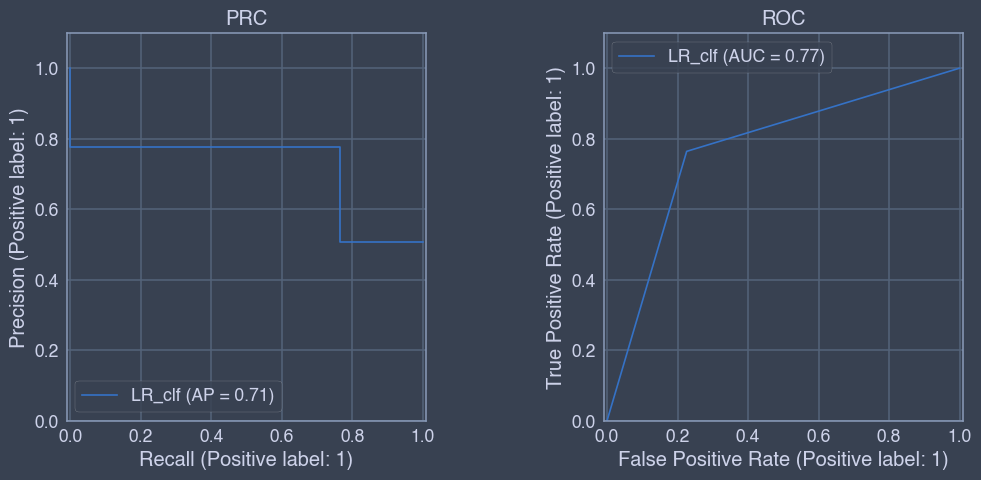

In [32]:
depict_pr_roc(y_test, grid.predict(X_test), 'LR_clf')

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

random_clas metrics:
AUC-PR: 0.5057
AUC-ROC: 0.5000
LR_clf metrics:
AUC-PR: 0.8341
AUC-ROC: 0.8447
SVM metrics:
AUC-PR: 0.7138
AUC-ROC: 0.7658


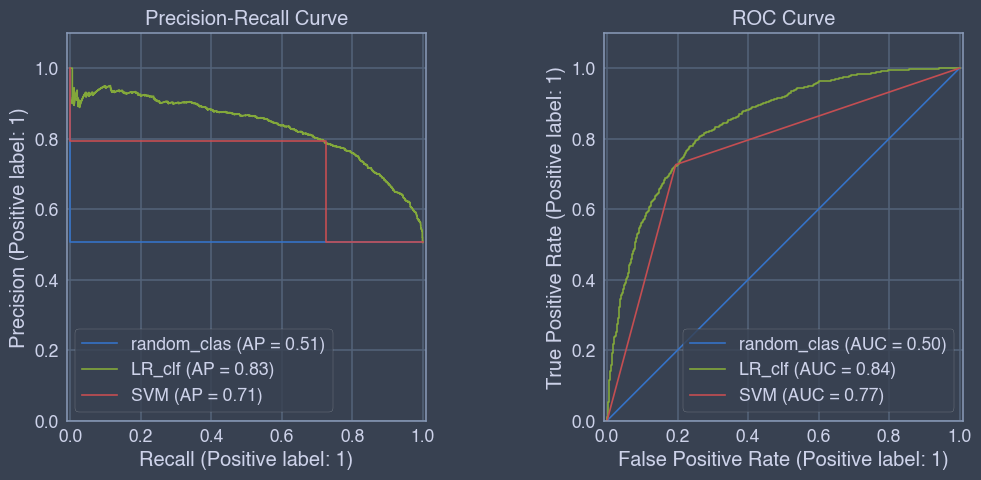

In [34]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None, show_plot=False):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    
    print(f"{classifier_name} metrics:")
    pr_auc_val = average_precision_score(y_true, y_pred)
    roc_auc_val = roc_auc_score(y_true, y_pred)
    print('AUC-PR: %.4f' % pr_auc_val)
    print('AUC-ROC: %.4f' % roc_auc_val)
    
    # PR кривая
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    ax[0].set_title("Precision-Recall Curve")
    ax[0].set_ylim(0, 1.1)
    
    # ROC кривая
    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    ax[1].set_title("ROC Curve")
    ax[1].set_ylim(0, 1.1)
    
    if show_plot:
        plt.tight_layout()
        plt.show()
        
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

predictions = {
    "random_clas" : y_random,
    "LR_clf": y_lr,   # вероятностные предсказания Logistic Regression
    "SVM": y_svm      # вероятностные предсказания SVM
}

for classifier_name in ["random_clas", "LR_clf", "SVM"]:
    y_pred = predictions.get(classifier_name)
    if y_pred is not None:
        depict_pr_roc(y_test, y_pred, classifier_name=classifier_name, ax=ax)
        
plt.tight_layout()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** явно можно ответить что ЛР превосходит свм в данной(!) задаче. скорее всего лр справилась лучше, потому что make_clas в начале генерирует более линейные зависимости, с которыми лучше справляется логистическая функция потерь. очев, что это только пример и на практике svm может обойти, так как более устойчив к шуму при правильных ядрах

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [39]:
X_2, y_2 = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42
)

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

In [40]:
from sklearn import svm

clf_svm = svm.SVC(kernel = 'linear', random_state = 42)
clf_svm.fit(X_train_2d, y_train_2d)

SVC(kernel='linear', random_state=42)

In [41]:
def plot_svm_2D(X, y, model, plot_support = True):
    # Создали сетку точек для визуализации
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=20, edgecolors='k')

    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                    model.support_vectors_[:, 1],
                    s=100, linewidth=1, edgecolor="blue",
                    facecolors='none', label='Support Vectors')

    plt.legend()
    plt.show()




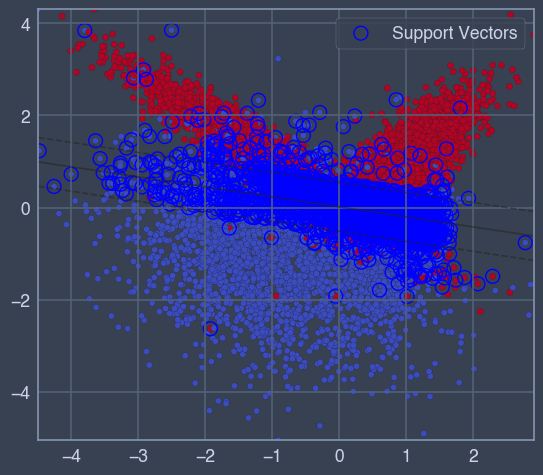

In [42]:
plot_svm_2D(X_2, y_2, clf_svm)

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_2d = clf_svm.predict(X_test_2d)

accuracy = accuracy_score(y_test_2d, y_pred_2d)
precision = precision_score(y_test_2d, y_pred_2d)
recall = recall_score(y_test_2d, y_pred_2d)
f1 = f1_score(y_test_2d, y_pred_2d)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1:.5f}")


Accuracy: 0.88667
Precision: 0.88636
Recall: 0.88636
F1-score: 0.88636


**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** # те объекты, которые ближе к разделяющей линии, гиперплоскости

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [47]:
from sklearn.linear_model import LogisticRegression


lr_clf = LogisticRegression(penalty = "l2", max_iter = 1000)
lr_clf.fit(X_train_2d, y_train_2d)


LogisticRegression(max_iter=1000)

In [48]:
print("X shape:", X_2.shape)
print("y shape:", y_2.shape)


X shape: (10000, 2)
y shape: (10000,)


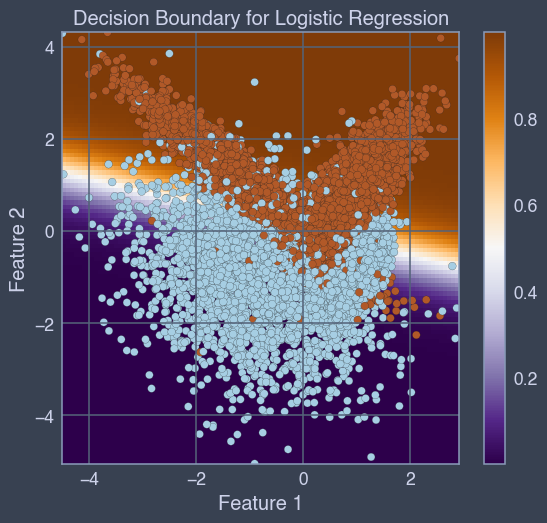

In [49]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )
    
    plt.scatter(
        X[:, 0],              
        X[:, 1],               
        c=y,                
        edgecolors='k',       
        cmap=plt.cm.Paired     
    )
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary for Logistic Regression')
    plt.colorbar(image)
    plt.show()

plot_logreg_2D(X_2, y_2, lr_clf)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** равные вероятности принадлежности к классам, модель провела разделяющую линию, но на каких то объектах вышла вероятность 0.5. градиентом выделены классы, белый там, где модель не может максимизировать уверенность.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

`https://scikit-learn.ru/stable/modules/calibration.html` - очень полезная статья литерали 

In [56]:
def plot_calibration_curve(y_test, preds, label = None):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # здесь было ((l -r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # здесь было np.min(...)
    plt.plot(bin_middle_points, bin_real_ratios, label = label)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.legend()
    

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [58]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [59]:
model_svm = svm.SVC(kernel = 'rbf', probability = True, random_state = 42)
model_svm.fit(X_train, y_train)

model_lr = LogisticRegression(penalty = "l2", max_iter = 1000)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [60]:
y_pred_svm = model_svm.predict_proba(X_test)
y_pred_lr = model_lr.predict_proba(X_test)

In [61]:
print(y_pred_svm.shape)
print(y_pred_lr.shape)

(3000, 2)
(3000, 2)


In [62]:
print(y_pred_svm[:, 1])
print(y_pred_lr[:, 1])


[0.99713288 0.01459337 0.01349784 ... 0.00993142 0.98493374 0.93460518]
[0.70881141 0.01240275 0.17901327 ... 0.05978296 0.86494925 0.92857818]


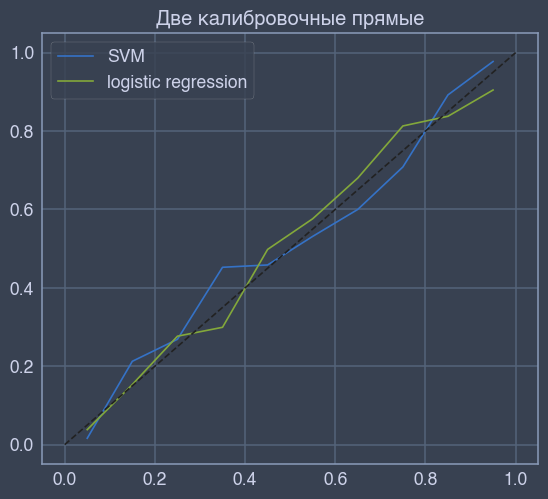

In [63]:
plot_calibration_curve(y_test, y_pred_svm[:, 1], label = 'SVM')
plot_calibration_curve(y_test, y_pred_lr[:, 1], label = 'logistic regression')
plt.plot([0, 1], [0, 1], 'k--', label='идеальная калибровка (y = x)')
plt.title("Две калибровочные прямые")
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** свм немного борщит с вероятностями, переоценивает, необходима еще настройка. можно использовать `СalibratedClassifierCV` из `scikit-learn`, а вот lr показывает хорошие вероятности

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [65]:
import numpy as np
from sklearn.metrics import log_loss, brier_score_loss

print(f"log loss svm: {log_loss(y_test, y_pred_svm[:, 1]):.3f}")
print(f"log loss LogReg: {log_loss(y_test, y_pred_lr[:, 1]):.3f}")
print(f"BrierScore SVM: {brier_score_loss(y_test, y_pred_svm[:, 1]):.3f}")
print(f"BrierScore LogReg: {brier_score_loss(y_test, y_pred_lr[:, 1]):.3f}")

log loss svm: 0.170
log loss LogReg: 0.486
BrierScore SVM: 0.046
BrierScore LogReg: 0.159


выводы: обе модели хорошо откалиброваны, это видно из разниц ошибок, BrierScore оценивает вероятность в более широком/глобальном, смысле, поэтому svm лучше оценён, он лучше учитывает размерности. это можно наглядно показать, если бы размерность признаков была 100, а не 10, тогда Brierscore svm отличался значительнее

Изучите распределение ответов классификаторов при помощи гистограмм

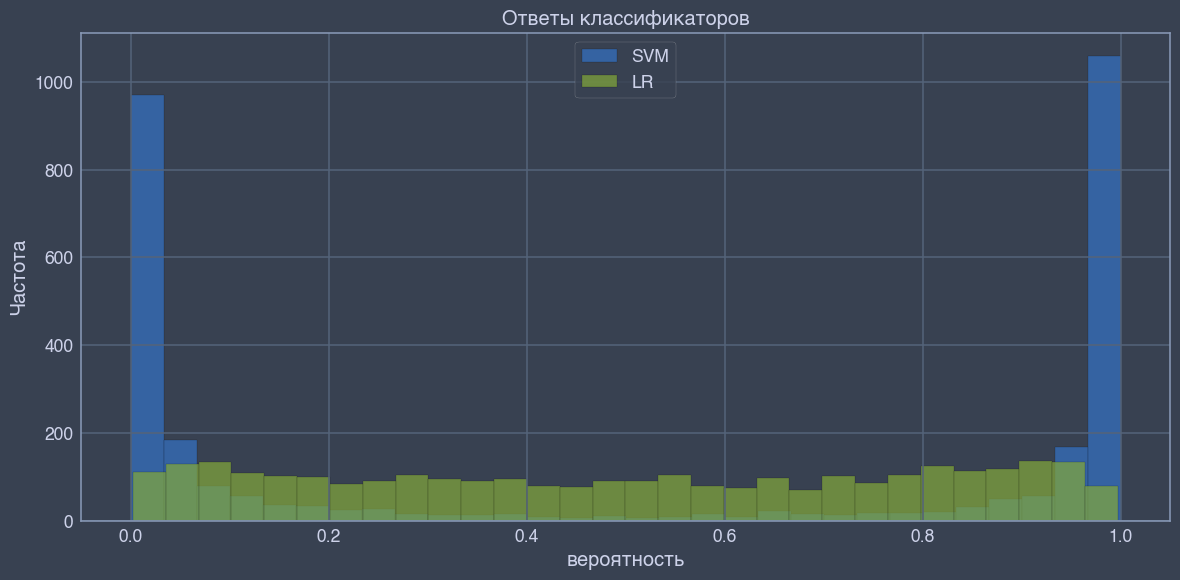

In [68]:

plt.figure(figsize=(12, 6))

plt.hist(y_pred_svm[:, 1], bins=30, alpha=0.7,edgecolor='black', label = 'SVM')

plt.hist(y_pred_lr[:, 1], bins=30, alpha=0.7, edgecolor = 'black', label = 'LR')
plt.title("Ответы классификаторов")
plt.xlabel("вероятность")
plt.ylabel("Частота")
plt.legend()
plt.tight_layout()
plt.show()


**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** лог регрессия дает распределение данных, а свм более жестко относится к бинарной классификации

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [72]:
from sklearn.calibration import CalibratedClassifierCV

model_svm = svm.SVC(kernel = 'rbf', random_state = 42)
calibrated_clf = CalibratedClassifierCV(model_svm, cv=3)

calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=3, estimator=SVC(random_state=42))

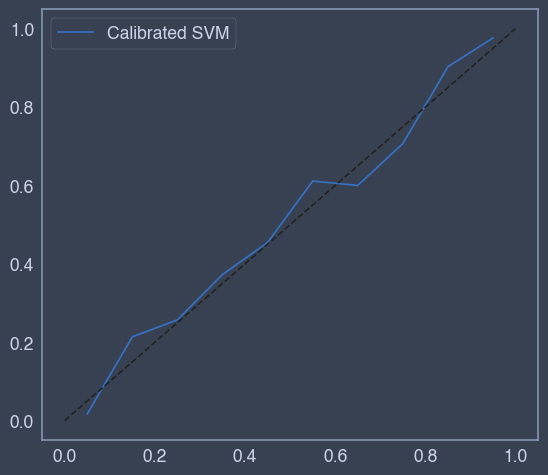

log loss calibrated svm: 0.170
BrierScore calibrated SVM: 0.047


In [73]:
y_pred_calibrated_svm = calibrated_clf.predict_proba(X_test)[:,1]
plot_calibration_curve(y_test, y_pred_calibrated_svm, label = 'Calibrated SVM')
plt.plot([0, 1], [0, 1], 'k--', label='идеальная калибровка (y = x)')
plt.show()


print(f"log loss calibrated svm: {log_loss(y_test, y_pred_calibrated_svm):.3f}")
print(f"BrierScore calibrated SVM: {brier_score_loss(y_test, y_pred_calibrated_svm):.3f}")


**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** бриер скор увеличился, но на 0.01 всего. также,  прямая ближе к идеальной y=x

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

`https://scikit-learn.ru/stable/modules/classes.html#module-sklearn.isotonic` брал отсюда инфу

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [81]:
df = pd.read_csv('bike_buyers.csv')
df = pd.DataFrame(df)

In [82]:
df

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,NaN,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


In [83]:
df['Purchased Bike'] = df['Purchased Bike'].map({'No': 0, 'Yes': 1})


X = df.drop('Purchased Bike', axis = 1)
y = df['Purchased Bike']

categorical_сols = ['Marital Status', 'Gender','Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']
numeric_cols = ['Income', 'Children', 'Cars', 'Age']

X_categorical = X[categorical_сols].copy()
X_numeric = X[numeric_cols].copy()

X_categorical = X_categorical.fillna("undefined")

В начале поработаем только с категориальными признаками

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [86]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
from sklearn.linear_model import LogisticRegression
import time

start_time = time.time()

enc_X = OrdinalEncoder()
X_encoded = enc_X.fit_transform(X_categorical)

enc_y = OrdinalEncoder()
y_reshaped = np.array(y).reshape(-1, 1)
y_encoded = enc_y.fit_transform(y_reshaped).ravel()


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.25, random_state=777, stratify=y_encoded
)

model_lr = LogisticRegression(penalty="l2", max_iter=1000)
model_lr.fit(X_train, y_train)

execution_time = time.time() - start_time

y_pred = model_lr.predict_proba(X_test)
y_scores = y_pred[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)

auc_pr = auc(recall, precision)
ap_score = average_precision_score(y_test, y_scores)

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Average Precision Score: {ap_score:.4f}")
print(f"Время выполнения: {execution_time:.4f} секунд")


AUC-PR: 0.5793
Average Precision Score: 0.5887
Время выполнения: 0.0065 секунд


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [89]:
from sklearn.preprocessing import OneHotEncoder

start_time = time.time()

onehotencoder_x = OneHotEncoder(sparse_output=False)
X_encodedOH = onehotencoder_x.fit_transform(X_categorical)

onehotencoder_y = OneHotEncoder(sparse_output=False)
y_reshaped = np.array(y).reshape(-1, 1)
y_onehot = onehotencoder_y.fit_transform(y_reshaped)
y_encodedOH = np.argmax(y_onehot, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_encodedOH, y_encodedOH, test_size=0.25, random_state=777, stratify=y_encodedOH
)

model_lr = LogisticRegression(penalty="l2", max_iter=1000)
model_lr.fit(X_train, y_train)

execution_time = time.time() - start_time

y_pred = model_lr.predict_proba(X_test)
y_scores = y_pred[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)
ap_score = average_precision_score(y_test, y_scores)

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Average Precision Score: {ap_score:.4f}")
print(f"Время выполнения: {execution_time:.4f} секунд")


AUC-PR: 0.6615
Average Precision Score: 0.6663
Время выполнения: 0.0286 секунд


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [100]:
def mean_target_encoding(X_cat, y, df, target_column):
    X_cat_te = X_cat.copy()
    for col in X_cat.columns:
        mapping = df.groupby(col)[target_column].mean()
        X_cat_te[col] = X_cat[col].map(mapping)
    return X_cat_te

start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)
df_train = X_train.copy()
df_train['Purchased Bike'] = y_train

X_train_encoded = mean_target_encoding(X_train, y_train, df_train, 'Purchased Bike')

X_test_encoded = X_test.copy()
for col in X_test.columns:
    mapping = df_train.groupby(col)['Purchased Bike'].mean()
    X_test_encoded[col] = X_test[col].map(mapping)
    X_test_encoded[col] = X_test_encoded[col].fillna(y_train.mean())

    
model_lr = LogisticRegression(penalty="l2", max_iter=1000)
model_lr.fit(X_train_encoded, y_train)

y_pred = model_lr.predict_proba(X_test_encoded)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr = auc(recall, precision)
ap_score = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Average Precision Score: {ap_score:.4f}")
print(f"Время выполнения: {time.time() - start_time:.4f} секунд")


AUC-PR: 0.6527
Average Precision Score: 0.6575
Время выполнения: 0.0146 секунд


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [95]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features

    def fit(self, X, y):
        self.mappings_ = {}
        for col in self.categorical_features:
            df_temp = pd.DataFrame({col: X[col], 'target': y})
            self.mappings_[col] = df_temp.groupby(col)['target'].mean()  # считаем среднюю целевую по признакам
        self.global_target_mean_ = y.mean() # считаем глобальное среднее, если есть пропуски (у нас в задаче пропуски заменены на undefined)
        return self

    def transform(self, X):
        X_out = X.copy()
        for col in self.categorical_features:
            X_out[col] = X_out[col].map(self.mappings_[col]).fillna(self.global_target_mean_) # делаем замены на соответствующие средние
        return X_out

In [116]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

encoder = MeanTargetEncoder(categorical_features=categorical_сols)
encoder.fit(X_train, y_train)
X_train_encoded = encoder.transform(X_train)
X_test_encoded  = encoder.transform(X_test)

model_lr = LogisticRegression(penalty="l2", max_iter=1000)
model_lr.fit(X_train_encoded, y_train)

y_pred = model_lr.predict_proba(X_test_encoded)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr = auc(recall, precision)
ap_score = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Average Precision Score: {ap_score:.4f}")
print(f"Время выполнения: {time.time() - start_time:.4f} секунд") # работает

AUC-PR: 0.6527
Average Precision Score: 0.6575
Время выполнения: 0.0080 секунд


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [102]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class MeanTargetEncoder_with_noise(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, noise):
        self.categorical_features = categorical_features
        self.noise = noise

    def fit(self, X, y):
        self.mappings_ = {}
        for col in self.categorical_features:
            df_temp = pd.DataFrame({col: X[col], 'target': y})
            self.mappings_[col] = df_temp.groupby(col)['target'].mean()  # считаем среднюю целевую по признакам
        self.global_target_mean_ = y.mean() # считаем глобальное среднее, если есть пропуски (у нас в задаче пропуски заменены на undefined)
        return self

    def transform(self, X):
        X_out = X.copy()
        for col in self.categorical_features:
            count = X_out[col].map(self.mappings_[col]).fillna(self.global_target_mean_) # делаем замены на соответствующие средние
            noise = np.random.normal(loc=0, scale=self.noise, size=count.shape) # хз, шум с каким то разбросом
            X_out[col] = count + noise # шумим
        return X_out

In [119]:
categorical_сols = ['Marital Status', 'Gender','Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']


start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

encoder = MeanTargetEncoder_with_noise(categorical_features=categorical_сols, noise = 0.001)
encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded  = encoder.transform(X_test)

model_lr = LogisticRegression(penalty="l2", max_iter=1000)
model_lr.fit(X_train_encoded, y_train)

y_train_pred = model_lr.predict_proba(X_train_encoded)[:, 1]
y_test_pred = model_lr.predict_proba(X_test_encoded)[:, 1]

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred)
auc_pr_train = auc(recall_train, precision_train)
auc_pr_test = auc(recall_test, precision_test)
ap_score_train = average_precision_score(y_train, y_train_pred)
ap_score_test = average_precision_score(y_test, y_test_pred)

print(f"X_train: AUC-PR = {auc_pr_train:.4f},  Average Precision Score = {ap_score_train:.4f}")
print(f"X_test:  AUC-PR = {auc_pr_test:.4f},  Average Precision Score = {ap_score_test:.4f}")

X_train: AUC-PR = 0.6338,  Average Precision Score = 0.6351
X_test:  AUC-PR = 0.6532,  Average Precision Score = 0.6563


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** # разумеется что метрики будут чуть падать в зависимости от шума, но зато боремся с переобучением. требовалось найти баланс, я считаю что 1e-3 баланс м/д переобучением и сохранении смысла признаков

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
# your code here
# мимо мимо)) 

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? 
> По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование 
> сглаживания средним по всей выборке:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} \mathbf{1} \{ f_j(x) = f_j(x_i) \} \mathbf{1} \{ y_i = +1 \} + C \cdot \text{global\_mean}}
{\sum_{i=1}^{\ell} \mathbf{1} \{ f_j(x) = f_j(x_i) \} + C}
$$

> где $\text{global\_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания
> (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории
> глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр 
> иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной 
> классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше, и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при 
использовании One-Hot-Encoding.


In [121]:

class MeanTargetEncoder_with_param(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features, C=10, noise=0.03):

        self.categorical_features = categorical_features
        self.C = C
        self.noise = noise

    def fit(self, X, y):
        self.global_target_mean_ = y.mean()
        self.mappings_ = {}

        for col in self.categorical_features:
            df_temp = pd.DataFrame({col: X[col], 'target': y})
            stats = df_temp.groupby(col)['target'].agg(['mean', 'count'])
            # Реализуем сглаживание по формуле
            stats['smoothed'] = (stats['mean'] * stats['count'] + self.C * self.global_target_mean_) / (stats['count'] + self.C)
            self.mappings_[col] = stats['smoothed']
        return self

    def transform(self, X):
        X_out = X.copy()
        for col in self.categorical_features:
            encoded = X_out[col].map(self.mappings_[col]).fillna(self.global_target_mean_)
            noise = np.random.normal(loc=0, scale=self.noise, size=encoded.shape)
            X_out[col] = encoded + noise
        return X_out


In [125]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

encoder = MeanTargetEncoder_with_param(categorical_features=categorical_сols, noise = 0.003, C = 8)
encoder.fit(X_train, y_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded  = encoder.transform(X_test)

model_lr = LogisticRegression(penalty="l2", max_iter=1000)
model_lr.fit(X_train_encoded, y_train)

y_train_pred = model_lr.predict_proba(X_train_encoded)[:, 1]
y_test_pred = model_lr.predict_proba(X_test_encoded)[:, 1]

precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred)
auc_pr_test = auc(recall_test, precision_test)
ap_score_test = average_precision_score(y_test, y_test_pred)

print(f"Напомню качество onehot энкодинга, AUC-PR: 0.6615,  Average Precision Score: 0.6663")
print(f"X_test:  AUC-PR = {auc_pr_test:.4f},  Average Precision Score = {ap_score_test:.4f}")

Напомню качество onehot энкодинга, AUC-PR: 0.6615,  Average Precision Score: 0.6663
X_test:  AUC-PR = 0.6744,  Average Precision Score = 0.6762


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



<Figure size 1200x600 with 0 Axes>

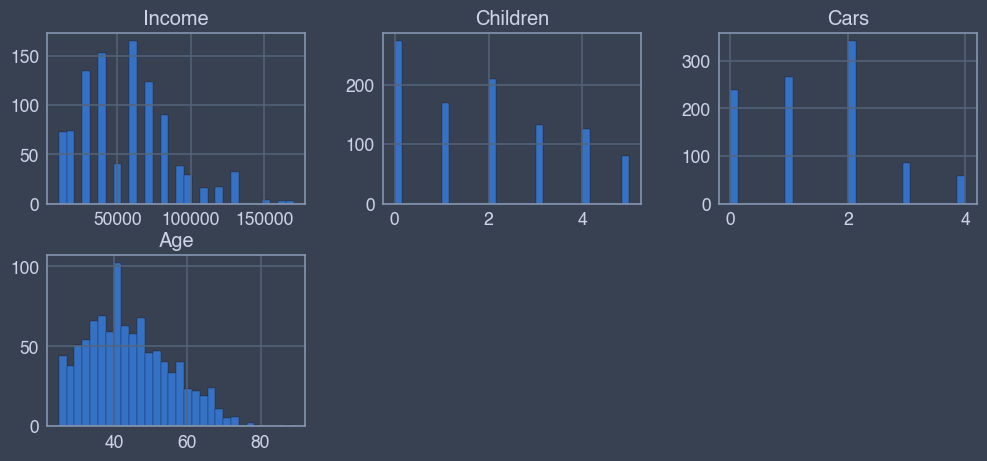

In [127]:
import seaborn as sns
plt.figure(figsize=(12, 6))
X_numeric.hist(bins=30, figsize=(12, 8), layout=(3, 3), edgecolor="black")
plt.show()

In [129]:
print(X_numeric.mean())
print(X_numeric.median())

Income      56267.605634
Children        1.910282
Cars            1.455096
Age            44.181452
dtype: float64
Income      60000.0
Children        2.0
Cars            1.0
Age            43.0
dtype: float64


In [131]:
lower_bound = df['Age'].quantile(0.05)
upper_bound = df['Age'].quantile(0.95)
X_numeric['Age'] = df['Age'].clip(lower=lower_bound, upper=upper_bound)

In [133]:
X_numeric = X_numeric.copy()

X_numeric.loc[:, 'Income'] = X_numeric['Income'].fillna(X_numeric['Income'].median())
X_numeric.loc[:, 'Cars'] = X_numeric['Cars'].fillna(X_numeric['Cars'].median())
X_numeric.loc[:, 'Children'] = X_numeric['Children'].fillna(X_numeric['Children'].mean())
X_numeric.loc[:, 'Age'] = X_numeric['Age'].fillna(X_numeric['Age'].mean())

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [136]:
# загптшил
class NumericCountEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_features, normalize=False):

        self.numeric_features = numeric_features
        self.normalize = normalize

    def fit(self, X, y=None):

        self.counts_ = {}
        total = X.shape[0]
        for col in self.numeric_features:
            counts = X[col].value_counts()
            if self.normalize:
                counts = counts / total
            self.counts_[col] = counts.to_dict()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.numeric_features:
            X_transformed[col] = X_transformed[col].map(self.counts_[col]).fillna(0)
        return X_transformed


In [152]:
start_time = time.time()

X_train_cat = X_categorical.loc[X_train.index].reset_index(drop=True)
X_test_cat  = X_categorical.loc[X_test.index].reset_index(drop=True)

X_train_numeric = X_numeric.loc[X_train.index].reset_index(drop=True)
X_test_numeric  = X_numeric.loc[X_test.index].reset_index(drop=True)

y_train = y.loc[X_train.index].reset_index(drop=True)
y_test  = y.loc[X_test.index].reset_index(drop=True)

cat_encoder = MeanTargetEncoder_with_param(categorical_features=categorical_сols,C=6,noise=0.0)
cat_encoder.fit(X_train_cat, y_train)
X_train_cat_encoded = cat_encoder.transform(X_train_cat)
X_test_cat_encoded  = cat_encoder.transform(X_test_cat)

num_encoder = NumericCountEncoder(numeric_features=numeric_cols)

num_encoder.fit(X_train_numeric)
X_train_numeric_encoded = num_encoder.transform(X_train_numeric)
X_test_numeric_encoded  = num_encoder.transform(X_test_numeric)

X_train_encoded = pd.concat([X_train_cat_encoded, X_train_numeric_encoded], axis=1)
X_test_encoded  = pd.concat([X_test_cat_encoded, X_test_numeric_encoded], axis=1)

model_lr = LogisticRegression(penalty="l2", max_iter=1000)
model_lr.fit(X_train_encoded, y_train)

y_pred = model_lr.predict_proba(X_test_encoded)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr = auc(recall, precision)
ap_score = average_precision_score(y_test, y_pred)

print(f"AUC-PR: {auc_pr:.4f}")
print(f"Average Precision Score: {ap_score:.4f}")
print(f"Время выполнения: {time.time() - start_time:.4f} секунд")

AUC-PR: 0.6766
Average Precision Score: 0.6784
Время выполнения: 0.0423 секунд


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ по итогу на одну десятую повысили метрики, плюс в том что мы экономим память(OHE слишком много признаков создает при кодировании) и mean-target быстрее

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [ ]:
curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [237]:


columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.


In [239]:
X = df.drop("income", axis = 1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [242]:
# Кодируем категориальные переменные
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
X_cat_train = X_train[categorical_columns]
X_cat_test = X_test[categorical_columns]

encoder = OneHotEncoder(drop='first', sparse_output=False)

# Обучаем кодер на тренировочных данных
X_cat_train_encoded = encoder.fit_transform(X_cat_train)

# Преобразуем тестовые данные, используя обученный кодер
X_cat_test_encoded = encoder.transform(X_cat_test)  # Исправлено!

# Конвертируем в DataFrame
X_train_cat_df = pd.DataFrame(X_cat_train_encoded, columns=encoder.get_feature_names_out())
X_test_cat_df = pd.DataFrame(X_cat_test_encoded, columns=encoder.get_feature_names_out())

In [244]:
from sklearn.preprocessing import StandardScaler
numeric_columns = X_train.drop(columns=categorical_columns).columns
scaler = StandardScaler()

X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_numeric_scaled = scaler.transform(X_test[numeric_columns])

X_train_numeric_df = pd.DataFrame(X_train_numeric_scaled, columns=numeric_columns)
X_test_numeric_df = pd.DataFrame(X_test_numeric_scaled, columns=numeric_columns)

X_train = pd.concat([X_train_numeric_df.reset_index(drop=True), X_train_cat_df], axis=1)
X_test = pd.concat([X_test_numeric_df.reset_index(drop=True), X_test_cat_df], axis=1)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [247]:
model_lr = LogisticRegression(penalty="l2", max_iter=30000)
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_pr_first = auc(recall, precision)
print(f"Результат модели для OHE:{auc_pr_first:4f}")

Результат модели для OHE:0.767255


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [275]:
X_train_main, X_valid, y_train_main, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=777)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [263]:
start_time = time.time()

model_lr = LogisticRegression(penalty="l2", max_iter=5000)
model_lr.fit(X_train_main, y_train_main)

feature_importance = np.abs(model_lr.coef_).flatten()

top_40_indices = np.argsort(feature_importance)[-40:]
selected_features = X_train_main.columns[top_40_indices]

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Время отбора: {elapsed_time:.4f}")
X_train_selected = X_train_main[selected_features]
X_valid_selected = X_valid[selected_features]

X_test_selected  = X_test[selected_features]

model_lr_selected = LogisticRegression(penalty="l2", max_iter=5000)
model_lr_selected.fit(X_train_selected, y_train_main)

y_pred_prob = model_lr_selected.predict_proba(X_test_selected)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr_second = auc(recall, precision)

print(f"Результат модели с топ 40: {auc_pr_second:.4f}")

Время отбора: 0.1727
Результат модели с топ 40: 0.7418


Изменилось ли качество? Как?

да не шибко оно ухудшилось, зато улучшилось время выполнения и затраты на обучения

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [268]:

scaler = StandardScaler()

X_train_main_scaled = pd.DataFrame(scaler.fit_transform(X_train_main),
                                   columns=X_train_main.columns,
                                   index=X_train_main.index)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid),
                              columns=X_valid.columns,
                              index=X_valid.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns,
                             index=X_test.index)

model_full = LogisticRegression(max_iter=1000, random_state=42)
model_full.fit(X_train_main_scaled, y_train_main)
y_pred_prob_full = model_full.predict_proba(X_test_scaled)[:, 1]
precision_full, recall_full, _ = precision_recall_curve(y_test, y_pred_prob_full)
auc_pr_full = auc(recall_full, precision_full)
print("AUC-PR модели на всех масштабированных признаках: {:.4f}".format(auc_pr_full))


start_time = time.time()

model_lr_scaled = LogisticRegression(max_iter=5000, random_state=42)
model_lr_scaled.fit(X_train_main_scaled, y_train_main)

coefs_scaled = model_lr_scaled.coef_[0]
feature_importance_scaled = np.abs(coefs_scaled)

top_40_indices_scaled = np.argsort(feature_importance_scaled)[-40:]
selected_features_scaled = X_train_main_scaled.columns[top_40_indices_scaled]

elapsed_time = time.time() - start_time

print("\n[Масштабированные данные]")
print("Время отбора признаков: {:.4f} секунд".format(elapsed_time))

X_train_selected = X_train_main_scaled[selected_features_scaled]
X_valid_selected = X_valid_scaled[selected_features_scaled]
X_test_selected  = X_test_scaled[selected_features_scaled]

model_lr_selected = LogisticRegression(max_iter=1000, random_state=42)
model_lr_selected.fit(X_train_selected, y_train_main)
y_pred_prob_selected = model_lr_selected.predict_proba(X_test_selected)[:, 1]
precision_sel, recall_sel, _ = precision_recall_curve(y_test, y_pred_prob_selected)
auc_pr_selected = auc(recall_sel, precision_sel)
print("AUC-PR модели с топ-40 признаками (масштабированные данные): {:.4f}".format(auc_pr_selected))

AUC-PR модели на всех масштабированных признаках: 0.7652

[Масштабированные данные]
Время отбора признаков: 0.0628 секунд
AUC-PR модели с топ-40 признаками (масштабированные данные): 0.7654


Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [284]:
X_train_main_scaled = pd.DataFrame(scaler.fit_transform(X_train_main),
                                   columns=X_train_main.columns,
                                   index=X_train_main.index)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid),
                              columns=X_valid.columns,
                              index=X_valid.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns,
                             index=X_test.index)

model_full_scaled = LogisticRegression(max_iter=1000, random_state=42)
model_full_scaled.fit(X_train_main_scaled, y_train_main)
y_pred_prob_full_scaled = model_full_scaled.predict_proba(X_test_scaled)[:, 1]
precision_full_scaled, recall_full_scaled, _ = precision_recall_curve(y_test, y_pred_prob_full_scaled)
auc_pr_full_scaled = auc(recall_full_scaled, precision_full_scaled)
print("AUC-PR на всех отскалированных one-hot признаках: {:.4f}".format(auc_pr_full_scaled))


start_time = time.time()

model_lr_scaled = LogisticRegression(max_iter=5000, random_state=42)
model_lr_scaled.fit(X_train_main_scaled, y_train_main)

coefs_scaled = model_lr_scaled.coef_[0]
feature_importance_scaled = np.abs(coefs_scaled)

top_40_indices_scaled = np.argsort(feature_importance_scaled)[-40:]
selected_features_scaled = X_train_main_scaled.columns[top_40_indices_scaled]

elapsed_time = time.time() - start_time
print("\n[Отбор признаков на отскалированных one-hot данных]")
print("Время отбора признаков: {:.4f} секунд".format(elapsed_time))
print("Отобранные признаки:", list(selected_features_scaled))

X_train_selected = X_train_main_scaled[selected_features_scaled]
X_valid_selected = X_valid_scaled[selected_features_scaled]
X_test_selected  = X_test_scaled[selected_features_scaled]

model_lr_selected = LogisticRegression(max_iter=1000, random_state=42)
model_lr_selected.fit(X_train_selected, y_train_main)
y_pred_prob_selected = model_lr_selected.predict_proba(X_test_selected)[:, 1]
precision_sel, recall_sel, _ = precision_recall_curve(y_test, y_pred_prob_selected)
auc_pr_selected = auc(recall_sel, precision_sel)
print("AUC-PR модели с топ-40 отскалированными one-hot признаками: {:.4f}".format(auc_pr_selected))

AUC-PR на всех отскалированных one-hot признаках: 0.7652

[Отбор признаков на отскалированных one-hot данных]
Время отбора признаков: 0.0688 секунд
Отобранные признаки: ['fnlwgt', 'occupation_ Adm-clerical', 'education_ HS-grad', 'native-country_ United-States', 'marital-status_ Separated', 'occupation_ Handlers-cleaners', 'marital-status_ Married-AF-spouse', 'workclass_ Self-emp-inc', 'native-country_ Columbia', 'education_ Some-college', 'relationship_ Unmarried', 'occupation_ Protective-serv', 'education_ Prof-school', 'native-country_ Outlying-US(Guam-USVI-etc)', 'workclass_ Without-pay', 'occupation_ Tech-support', 'education_ Doctorate', 'race_ White', 'occupation_ Sales', 'education_ Masters', 'occupation_ Farming-fishing', 'workclass_ Federal-gov', 'education_ Bachelors', 'relationship_ Not-in-family', 'occupation_ Other-service', 'workclass_ Private', 'occupation_ Prof-specialty', 'relationship_ Own-child', 'capital-loss', 'relationship_ Wife', 'marital-status_ Never-married',

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** по факту корреляция признака и цел переменной показывает насколько сильно связан с этой самой целевой переменной. идея, что чем выше корреляция у iго-признака, тем больше признак влияет на предсказание модели. можно посчитать корреляцию между всему признаками и выбрать какой нибудь порог. получится хорошая функция фильтрации признаков

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [281]:

def compute_feature_correlations(X, y):
    return X.corrwith(y)
corr = compute_feature_correlations(X_valid, y_valid)

top_40_features = corr.sort_values(ascending=False).index[:40]
print("Выбранные 40 признаков:", list(top_40_features))

Выбранные 40 признаков: ['education_ HS-grad', 'marital-status_ Separated', 'capital-gain', 'age', 'native-country_ Guatemala', 'native-country_ Thailand', 'occupation_ Tech-support', 'relationship_ Unmarried', 'workclass_ State-gov', 'occupation_ Other-service', 'relationship_ Wife', 'native-country_ Poland', 'native-country_ United-States', 'race_ White', 'marital-status_ Widowed', 'occupation_ Transport-moving', 'occupation_ Craft-repair', 'workclass_ Local-gov', 'native-country_ Dominican-Republic', 'native-country_ England', 'education_ Masters', 'marital-status_ Married-civ-spouse', 'education_ Assoc-acdm', 'hours-per-week', 'native-country_ Canada', 'native-country_ Puerto-Rico', 'fnlwgt', 'marital-status_ Married-spouse-absent', 'education_ 12th', 'education_ 5th-6th', 'education-num', 'occupation_ Exec-managerial', 'workclass_ Private', 'capital-loss', 'education_ Bachelors', 'occupation_ Sales', 'occupation_ Farming-fishing', 'native-country_ India', 'relationship_ Other-rela

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [286]:
X_train_filtered = X_train_main[top_40_features]


model_lr_selected = LogisticRegression(penalty="l2", max_iter=10000)
model_lr_selected.fit(X_train_filtered, y_train_main)

y_pred_prob = model_lr_selected.predict_proba(X_test[top_40_features])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr = auc(recall, precision)

print(f"Результат модели на отобранных 40 признаках (AUC-PR): {auc_pr:.4f}")

Результат модели на отобранных 40 признаках (AUC-PR): 0.7553


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [296]:

def compute_t_statistics(X, y):
    y = y.reindex(X.index)
    t_stats = {}
    for col in X.columns:
        pos = X.loc[y == 1, col]
        neg = X.loc[y == 0, col]
        
        n_pos = pos.shape[0]
        n_neg = neg.shape[0]
        
        mean_pos = pos.mean()
        mean_neg = neg.mean()
        var_pos = pos.var(ddof=1)
        var_neg = neg.var(ddof=1)
        denom = np.sqrt((n_pos * var_pos + n_neg * var_neg) / (n_pos + n_neg))
        
        t_val = np.abs(mean_pos - mean_neg) / denom
        t_stats[col] = t_val
    
    return pd.Series(t_stats)
start_time = time.time()

t_stats_series = compute_t_statistics(X_train_main, y_train_main)

sorted_t_stats = t_stats_series.sort_values(ascending=False)
top_40_features = sorted_t_stats.index[:40]

elapsed_time = time.time() - start_time
print(f"Время отбора признаков по t-статистике: {elapsed_time:.4f} секунд")
print("Top 40 features:", list(top_40_features))

X_train_top40 = X_train_main[top_40_features]
X_test_top40 = X_test[top_40_features]

model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_top40, y_train_main)

y_pred_prob = model_lr.predict_proba(X_test_top40)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
auc_pr_value = auc(recall, precision)
print(f"AUC-PR модели на тестовой выборке с top-40 признаками: {auc_pr_value:.4f}")


Время отбора признаков по t-статистике: 0.0486 секунд
Top 40 features: ['workclass_ Private', 'workclass_ Without-pay', 'workclass_ Self-emp-inc', 'capital-loss', 'native-country_ Hong', 'occupation_ Handlers-cleaners', 'native-country_ Haiti', 'education_ HS-grad', 'race_ Other', 'native-country_ England', 'marital-status_ Married-AF-spouse', 'native-country_ El-Salvador', 'education_ Some-college', 'relationship_ Unmarried', 'education_ 7th-8th', 'hours-per-week', 'native-country_ France', 'native-country_ Columbia', 'native-country_ Greece', 'native-country_ Ireland', 'native-country_ Italy', 'relationship_ Wife', 'relationship_ Other-relative', 'workclass_ Local-gov', 'occupation_ Exec-managerial', 'native-country_ Trinadad&Tobago', 'fnlwgt', 'education-num', 'education_ Prof-school', 'education_ 5th-6th', 'native-country_ Guatemala', 'native-country_ South', 'native-country_ Thailand', 'education_ 1st-4th', 'native-country_ Honduras', 'native-country_ Scotland', 'native-country_ H

/var/folders/z5/3lbr_mgd2vs1f1qrg87y967h0000gn/T/ipykernel_84109/3747152791.py:17: RuntimeWarning: invalid value encountered in scalar divide
  t_val = np.abs(mean_pos - mean_neg) / denom


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [298]:
# ...

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [300]:
# ...

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** наилучшим оказался встроенный метод и по времени и по метрике, худшим можно назвать t статистику, может я что то неверно реализовал или протестировал, но не нашел ошибки в коде. последний метод не знаю как закодить, но смысл понятен)


# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [307]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [309]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [366]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [424]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=10,
    random_state=42,
    shuffle=True,
    cat_features = None,
    C_value = None
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        if cat_features is not None:
            encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
            X_train_cat = encoder.fit_transform(X_train[cat_features])
            X_test_cat = encoder.transform(X_test[cat_features])
            
            X_train_num = X_train.drop(columns=cat_features)
            X_test_num = X_test.drop(columns=cat_features)
            
            scaler = StandardScaler()
            X_train_num = scaler.fit_transform(X_train_num)
            X_test_num = scaler.transform(X_test_num)
            
            X_train = np.hstack((X_train_num, X_train_cat))
            X_test = np.hstack((X_test_num, X_test_cat))
        else:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        # возьмите датасет и обучите модель
        # your code here
        model = LogisticRegression(max_iter = 5000, C=C_value)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Метрика точности
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1_val = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        auc_pr = auc(recall_curve, precision_curve)
        tp_count = np.sum((y_test == 1) & (y_pred == 1))
        fp_count = np.sum((y_test == 0) & (y_pred == 1))
        
        tp_profit = np.sum(np.random.uniform(0, 20, tp_count)) - (tp_count * 2)
        fp_loss = fp_count * (-2)

        profit = tp_profit + fp_loss        
        metrics.append({
            "accuracy": acc,
            "recall": rec,
            "f1": f1_val,
            "roc_auc": roc_auc,
            "AUC-PR": auc_pr,
            "profit": profit
        })
    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [388]:
cat_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
#cat_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 14]
df_results = cross_validate(X, y, cat_features=cat_features)
df_results
# супер плохие резы, рекол должен быть гораздо лучше

,accuracy,recall,f1,roc_auc,AUC-PR
0,0.899247,0.227273,0.336000,0.793463,0.445858
1,0.894392,0.196617,0.299517,0.768382,0.413577
2,0.907016,0.253304,0.375204,0.797804,0.483539
3,0.899247,0.232759,0.342314,0.804309,0.464435
4,0.900461,0.251641,0.359375,0.768457,0.412943
5,0.891964,0.230159,0.342688,0.793036,0.482315
6,0.904103,0.218605,0.322470,0.786360,0.416305
7,0.907016,0.243304,0.362729,0.822228,0.490899
8,0.898494,0.202586,0.310231,0.786282,0.440214
9,0.898009,0.233471,0.349845,0.796089,0.468738


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [416]:
df_results = cross_validate(X, y, cat_features=cat_features)

total_calls = df_results["recall"] * len(y) + df_results["f1"] * len(y)
total_expenses = total_calls.mean() * 2

print(df_results)
print(f"mean:{df_results["profit"].mean():.4f}")
print(f"std:{df_results["profit"].std():.4f}")
print(f"Затраты:{total_expenses:.4f}")
print(f"корреляция с реколом:{df_results["profit"].corr(df_results["recall"]):.4f}")

   accuracy    recall        f1   roc_auc    AUC-PR  profit
0  0.899247  0.227273  0.336000  0.793463  0.445858     724
1  0.894392  0.196617  0.299517  0.768382  0.413577     634
2  0.907016  0.253304  0.375204  0.797804  0.483539     832
3  0.899247  0.232759  0.342314  0.804309  0.464435     746
4  0.900461  0.251641  0.359375  0.768457  0.412943     784
5  0.891964  0.230159  0.342688  0.793036  0.482315     814
6  0.904103  0.218605  0.322470  0.786360  0.416305     634
7  0.907016  0.243304  0.362729  0.822228  0.490899     784
8  0.898494  0.202586  0.310231  0.786282  0.440214     656
9  0.898009  0.233471  0.349845  0.796089  0.468738     806
mean:741.4000
std:75.9886
Затраты:46872.6933
корреляция с реколом:0.8565


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [420]:
df_results = cross_validate(X, y, cat_features=cat_features)

total_calls = df_results["recall"] * len(y) + df_results["f1"] * len(y)
total_expenses = total_calls.mean() * 2

print(df_results)
print(f"mean:{df_results["profit"].mean():.4f}")
print(f"std:{df_results["profit"].std():.4f}")
print(f"Затраты:{total_expenses:.4f}")
print(f"корреляция с реколом:{df_results["profit"].corr(df_results["recall"]):.4f}")

   accuracy    recall        f1   roc_auc    AUC-PR      profit
0  0.899247  0.227273  0.336000  0.793463  0.445858  805.096312
1  0.894392  0.196617  0.299517  0.768382  0.413577  597.994239
2  0.907016  0.253304  0.375204  0.797804  0.483539  726.649742
3  0.899247  0.232759  0.342314  0.804309  0.464435  668.865306
4  0.900461  0.251641  0.359375  0.768457  0.412943  890.685911
5  0.891964  0.230159  0.342688  0.793036  0.482315  802.533104
6  0.904103  0.218605  0.322470  0.786360  0.416305  539.644320
7  0.907016  0.243304  0.362729  0.822228  0.490899  792.320547
8  0.898494  0.202586  0.310231  0.786282  0.440214  689.181057
9  0.898009  0.233471  0.349845  0.796089  0.468738  745.329745
mean:725.8300
std:105.2727
Затраты:46872.6933
корреляция с реколом:0.6476


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

Best C = 20.6914 с максимальной средней прибылью = $766.7093


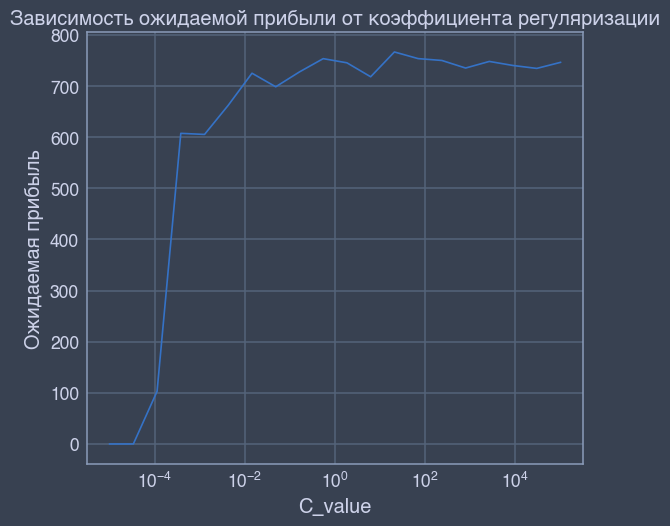

In [438]:
C_values = np.logspace(-5, 5, 20)


profits_mean = []
profits_std = []

for c_val in C_values:
    df_metrics = cross_validate(X, y, cat_features=cat_features, C_value=c_val)
    mean_profit = df_metrics["profit"].mean()
    std_profit = df_metrics["profit"].std()
    profits_mean.append(mean_profit)
    profits_std.append(std_profit)
    #print(f"C={c_val:.4f} \t средняя прибыль:{mean_profit:.4f} (std={std_profit:.4f})")

max_profit_index = np.argmax(profits_mean)
best_C = C_values[max_profit_index]
print(f"Best C = {best_C:.4f} с максимальной средней прибылью = ${profits_mean[max_profit_index]:.4f}")

plt.plot(C_values, profits_mean)
plt.xscale('log')
plt.xlabel('C_value')
plt.ylabel('Ожидаемая прибыль')
plt.title('Зависимость ожидаемой прибыли от коэффициента регуляризации')
plt.grid(True)
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Best C = 2636.6509 с максимальной средней прибылью = $765.7940


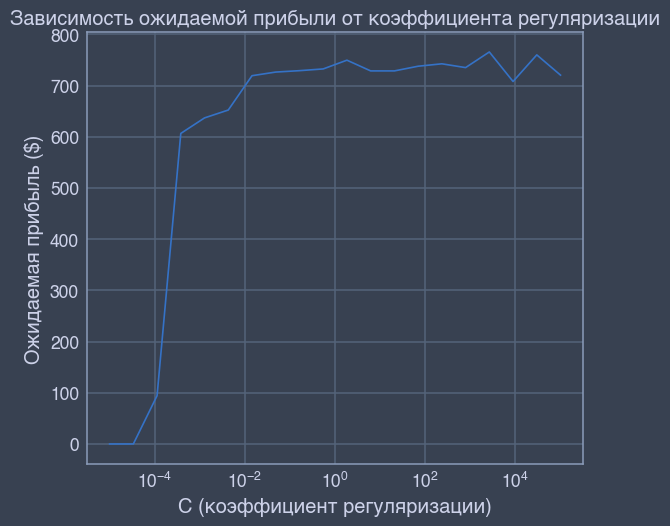

In [440]:
C_values = np.logspace(-5, 5, 20)


profits_mean = []
profits_std = []

for c_val in C_values:
    df_metrics = cross_validate(X, y, cat_features=cat_features, C_value=c_val)
    mean_profit = df_metrics["profit"].mean()
    std_profit = df_metrics["profit"].std()
    profits_mean.append(mean_profit)
    profits_std.append(std_profit)
    #print(f"C={c_val:.4f} \t средняя прибыль:{mean_profit:.4f} (std={std_profit:.4f})")

max_profit_index = np.argmax(profits_mean)
best_C = C_values[max_profit_index]
print(f"Best C = {best_C:.4f} с максимальной средней прибылью = ${profits_mean[max_profit_index]:.4f}")

sns.lineplot(x=C_values, y=profits_mean)
plt.xscale('log')
plt.xlabel("C (коэффициент регуляризации)")
plt.ylabel("Ожидаемая прибыль ($)")
plt.title("Зависимость ожидаемой прибыли от коэффициента регуляризации")
plt.grid(True)
plt.show()
# в целом присутствует закономерность, можно на графике обнаружить, что между только при положительных значениях параметра C, прибыль стабильна 
# средняя прибыль также стабильна, но конкретный параметр C каждый раз разный, но во всяком случае - точно положительный

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Конечно рекол, потому что нам необходимо как можно больше положительных звонков



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [457]:

def cross_validate_binarisation(
    X,
    y,
    cat_features=None,
    C_value=None,
    n_splits=10,
    random_state=42,
    shuffle=True,
    thresholds=np.arange(0, 1.01, 0.01)
):
    metrics = []
    all_fold_profits = []  # для сохранения прибыли по каждому порогу для каждого фолда
    all_fold_recalls = []  # для сохранения recall по каждому порогу для каждого фолда

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        # Копируем части выборки
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        # Предобработка
        if cat_features is not None:
            encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
            X_train_cat = encoder.fit_transform(X_train[cat_features])
            X_test_cat = encoder.transform(X_test[cat_features])
            
            X_train_num = X_train.drop(columns=cat_features)
            X_test_num = X_test.drop(columns=cat_features)
            
            scaler = StandardScaler()
            X_train_num = scaler.fit_transform(X_train_num)
            X_test_num = scaler.transform(X_test_num)
            
            X_train = np.hstack((X_train_num, X_train_cat))
            X_test = np.hstack((X_test_num, X_test_cat))
        else:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        # Обучение модели
        model = LogisticRegression(max_iter=5000, C=C_value)
        model.fit(X_train, y_train)

        # Получаем стандартное предсказание и вероятности
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Списки для текущего фолда для каждого порога
        fold_profit = []
        fold_recall = []
        
        # Перебор порогов бинаризации
        for thr in thresholds:
            y_pred_thr = (y_prob >= thr).astype(int)
            
            tp_count = np.sum((y_test == 1) & (y_pred_thr == 1))
            fp_count = np.sum((y_test == 0) & (y_pred_thr == 1))
            
            tp_profit = np.sum(np.random.uniform(0, 20, tp_count)) - (tp_count * 2)
            fp_loss   = fp_count * (-2)
            profit = tp_profit + fp_loss
            
            fold_profit.append(profit)
            fold_recall.append(recall_score(y_test, y_pred_thr))
        
        # Сохраняем результаты по текущему фолду
        all_fold_profits.append(fold_profit)
        all_fold_recalls.append(fold_recall)
        
        # Вычисляем стандартные метрики при стандартном пороге (обычно 0.5)
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1_val = f1_score(y_test, y_pred)
        roc_auc_val = roc_auc_score(y_test, y_prob)
        precision_curve, recall_curve_vals, _ = precision_recall_curve(y_test, y_prob)
        auc_pr_val = auc(recall_curve_vals, precision_curve)
        
        # Вычисляем прибыль при стандартном предсказании
        tp_count_def = np.sum((y_test == 1) & (y_pred == 1))
        fp_count_def = np.sum((y_test == 0) & (y_pred == 1))
        tp_profit_def = np.sum(np.random.uniform(0, 20, tp_count_def)) - (tp_count_def * 2)
        fp_loss_def = fp_count_def * (-2)
        profit_def = tp_profit_def + fp_loss_def
        
        metrics.append({
            "accuracy": acc,
            "recall": rec,
            "f1": f1_val,
            "roc_auc": roc_auc_val,
            "AUC-PR": auc_pr_val,
            "profit": profit_def
        })
    
    # Преобразуем результаты по порогам в NumPy-массивы
    all_fold_profits = np.array(all_fold_profits)  # shape (n_splits, len(thresholds))
    all_fold_recalls  = np.array(all_fold_recalls)
    
    mean_profit = all_fold_profits.mean(axis=0)
    std_profit  = all_fold_profits.std(axis=0)
    mean_recall = all_fold_recalls.mean(axis=0)
    
    grid_df = pd.DataFrame({
        "threshold": thresholds,
        "mean_profit": mean_profit,
        "std_profit": std_profit,
        "mean_recall": mean_recall
    })
    
    return grid_df


In [466]:
grid_df = cross_validate_binarisation(X, y, cat_features=cat_features, C_value=2000, n_splits=10)

best_row = grid_df.loc[grid_df["mean_profit"].idxmax()]
print(best_row)
best_threshold = best_row["threshold"]
print("Оптимальный порог бинаризации:", best_threshold)
corr = np.corrcoef(grid_df["mean_profit"], grid_df["mean_recall"])[0, 1]
print(f"Корреляция между прибылью и recall: {corr:.2f}")

threshold         0.200000
mean_profit    1450.053265
std_profit      121.655405
mean_recall       0.566711
Name: 20, dtype: float64
Оптимальный порог бинаризации: 0.2
Корреляция между прибылью и recall: -0.20


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




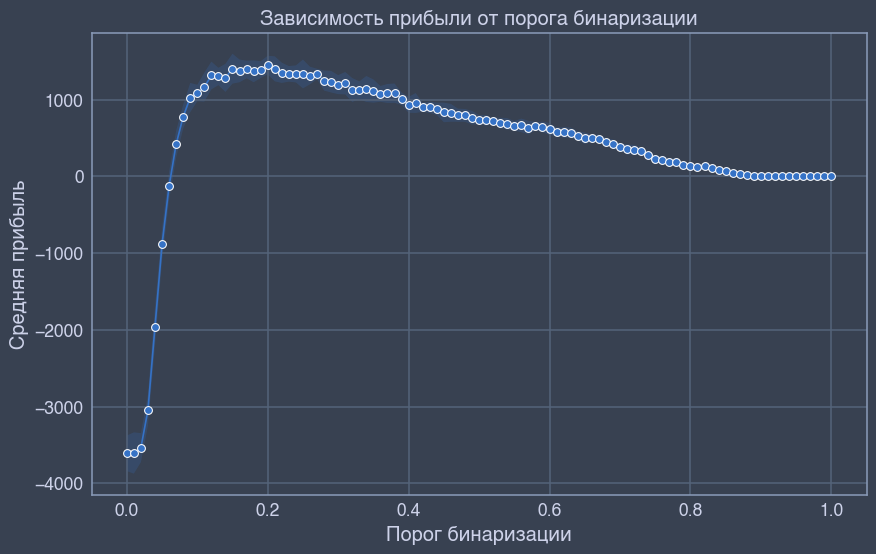

In [470]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="threshold", y="mean_profit", data=grid_df, marker="o")
plt.fill_between(
    grid_df["threshold"],
    grid_df["mean_profit"] - grid_df["std_profit"],
    grid_df["mean_profit"] + grid_df["std_profit"],
    alpha=0.2
)
plt.xlabel("Порог бинаризации")
plt.ylabel("Средняя прибыль")
plt.title("Зависимость прибыли от порога бинаризации")
plt.grid(True)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ наш результат это компромисс между истинными позитивными и ложноположительными случаями, это всегда будет оптимальным порогом для нашей задачи

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [484]:
# списал

from scipy.stats import ttest_rel

def cross_validate_binarisation(
    X,
    y,
    cat_features=None,
    C_value=None,
    n_splits=10,
    random_state=42,
    shuffle=True,
    thresholds=np.arange(0, 1.01, 0.01)
):

    metrics = []
    all_fold_profits = [] 
    all_fold_recalls = []
    default_profits = []  

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        
        if cat_features is not None:
            encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
            X_train_cat = encoder.fit_transform(X_train[cat_features])
            X_test_cat = encoder.transform(X_test[cat_features])
            
            X_train_num = X_train.drop(columns=cat_features)
            X_test_num = X_test.drop(columns=cat_features)
            
            scaler = StandardScaler()
            X_train_num = scaler.fit_transform(X_train_num)
            X_test_num = scaler.transform(X_test_num)
            
            X_train_proc = np.hstack((X_train_num, X_train_cat))
            X_test_proc = np.hstack((X_test_num, X_test_cat))
        else:
            scaler = StandardScaler()
            X_train_proc = scaler.fit_transform(X_train)
            X_test_proc = scaler.transform(X_test)

        model = LogisticRegression(max_iter=5000, C=C_value)
        model.fit(X_train_proc, y_train)
        y_pred = model.predict(X_test_proc)
        y_prob = model.predict_proba(X_test_proc)[:, 1]
        
        fold_profit = [] 
        fold_recall = []
        for thr in thresholds:
            y_pred_thr = (y_prob >= thr).astype(int)
            
            tp_count = np.sum((y_test == 1) & (y_pred_thr == 1))
            fp_count = np.sum((y_test == 0) & (y_pred_thr == 1))

            tp_profit = np.sum(np.random.uniform(0, 20, tp_count)) - (tp_count * 2)
            fp_loss = fp_count * (-2)
            profit = tp_profit + fp_loss
            
            fold_profit.append(profit)
            fold_recall.append(recall_score(y_test, y_pred_thr))
        
        all_fold_profits.append(fold_profit)
        all_fold_recalls.append(fold_recall)
        
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1_val = f1_score(y_test, y_pred)
        roc_auc_val = roc_auc_score(y_test, y_prob)
        precision_curve, recall_curve_vals, _ = precision_recall_curve(y_test, y_prob)
        auc_pr_val = auc(recall_curve_vals, precision_curve)
        
        tp_count_def = np.sum((y_test == 1) & (y_pred == 1))
        fp_count_def = np.sum((y_test == 0) & (y_pred == 1))
        tp_profit_def = np.sum(np.random.uniform(0, 20, tp_count_def)) - (tp_count_def * 2)
        fp_loss_def = fp_count_def * (-2)
        profit_def = tp_profit_def + fp_loss_def
        
        metrics.append({
            "accuracy": acc,
            "recall": rec,
            "f1": f1_val,
            "roc_auc": roc_auc_val,
            "AUC-PR": auc_pr_val,
            "profit": profit_def
        })
        

        model_default = LogisticRegression(max_iter=5000)  # C=1.0 по умолчанию
        model_default.fit(X_train_proc, y_train)
        y_prob_default = model_default.predict_proba(X_test_proc)[:, 1]
        y_pred_default = (y_prob_default >= 0.5).astype(int)
        
        tp_count_d = np.sum((y_test == 1) & (y_pred_default == 1))
        fp_count_d = np.sum((y_test == 0) & (y_pred_default == 1))
        tp_profit_d = np.sum(np.random.uniform(0, 20, tp_count_d)) - (tp_count_d * 2)
        fp_loss_d = fp_count_d * (-2)
        profit_default = tp_profit_d + fp_loss_d
        
        default_profits.append(profit_default)
    
    all_fold_profits = np.array(all_fold_profits)
    all_fold_recalls = np.array(all_fold_recalls)
    default_profits = np.array(default_profits) 
    
    mean_profit = all_fold_profits.mean(axis=0)
    std_profit = all_fold_profits.std(axis=0)
    mean_recall = all_fold_recalls.mean(axis=0)
    
    grid_df = pd.DataFrame({
        "threshold": thresholds,
        "mean_profit": mean_profit,
        "std_profit": std_profit,
        "mean_recall": mean_recall
    })
    
    best_idx = np.argmax(mean_profit)
    best_threshold = thresholds[best_idx]
    opt_best_profits = all_fold_profits[:, best_idx]
    

    t_stat, p_value = ttest_rel(opt_best_profits, default_profits)
    
    print("Оптимальный порог для оптимизированной модели:", best_threshold)
    print("Средняя прибыль оптимизированной модели:", np.mean(opt_best_profits), "+/-", np.std(opt_best_profits))
    print("Средняя прибыль дефолтной модели:", np.mean(default_profits), "+/-", np.std(default_profits))
    print("Парный t‑тест: t-статистика =", t_stat, ", p-value =", p_value)
    
    return grid_df, best_threshold, opt_best_profits, default_profits, t_stat, p_value


In [486]:
grid_df, best_threshold, opt_best_profits, default_profits, t_stat, p_value = cross_validate_binarisation(
    X, y, cat_features=cat_features, C_value=0.1
)


print("\nРезультаты кросс-валидации по различным порогам:")
print(grid_df)
print("\nЛучший порог (оптимизированная модель):", best_threshold)
print("Прибыли оптимизированной модели по фолдам:", opt_best_profits)
print("Прибыли дефолтной модели по фолдам:", default_profits)
print("Результаты парного t-теста: t-статистика =", t_stat, ", p-value =", p_value)

Оптимальный порог для оптимизированной модели: 0.17
Средняя прибыль оптимизированной модели: 1404.5109764245994 +/- 154.4136304963108
Средняя прибыль дефолтной модели: 725.1707461285083 +/- 95.6372566842884
Парный t‑тест: t-статистика = 16.04280816076702 , p-value = 6.284437105773987e-08

Результаты кросс-валидации по различным порогам:
     threshold  mean_profit  std_profit  mean_recall
0         0.00 -3601.608230  212.544508     1.000000
1         0.01 -3542.438852  238.548709     1.000000
2         0.02 -3515.723887  237.845355     0.997170
3         0.03 -3023.773134  275.392525     0.973538
4         0.04 -1868.179762  197.730202     0.922666
..         ...          ...         ...          ...
96        0.96     0.000000    0.000000     0.000000
97        0.97     0.000000    0.000000     0.000000
98        0.98     0.000000    0.000000     0.000000
99        0.99     0.000000    0.000000     0.000000
100       1.00     0.000000    0.000000     0.000000

[101 rows x 4 columns]



По итогу имеем хорошие результаты

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [491]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

100%|███████████████████████████████████████| 87.2k/87.2k [00:00<00:00, 691kB/s]

Extracting files...


In [497]:
df = pd.read_csv(path)
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,5,0,0,0,1,1,0,19,0,0,6,7,5,13.600000,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,15,1,1,19,1,1,10,10,1,0,1,0,0,0,18,1,0,6,6,6,12.000000,0,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,12,1,1,1,22,27,10,10,1,0,0,1,0,1,30,0,0,7,8,7,14.912500,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9,1,1,1,22,27,8,5,1,0,0,1,0,1,20,0,0,5,5,5,13.800000,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [499]:
unique_values = df["Target"].unique()
print(unique_values)

['Dropout' 'Graduate' 'Enrolled']


Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [509]:
from sklearn.preprocessing import LabelEncoder

numeric_features = ["Age at enrollment"]
categorical_features = ["Marital status", "Course", "Nacionality", "Gender"]

numeric_data = df[numeric_features]
categorical_data = df[categorical_features]

scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_data)
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_features)

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
categorical_encoded = encoder.fit_transform(categorical_data)
categorical_columns = encoder.get_feature_names_out(categorical_features)
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=categorical_columns)

X = pd.concat([numeric_scaled_df, categorical_encoded_df], axis=1)

label_encoder = LabelEncoder()
df["Target_encoded"] = label_encoder.fit_transform(df["Target"])
y = df["Target_encoded"]

In [511]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [518]:
start_ovr = time.time()
model_ovr = LogisticRegression(max_iter=10000, multi_class="ovr")
model_ovr.fit(X_train, y_train)
end_ovr = time.time()
ovr_training_time = end_ovr - start_ovr

start_ovo = time.time()
model_ovo = LogisticRegression(max_iter=10000, multi_class="multinomial", solver="lbfgs")
model_ovo.fit(X_train, y_train)
end_ovo = time.time()
ovo_training_time = end_ovo - start_ovo

print(f"Время обучения OvR: {ovr_training_time:.4f} секунд")
print(f"Время обучения OvO: {ovo_training_time:.4f} секунд")

Время обучения OvR: 0.0819 секунд
Время обучения OvO: 0.0360 секунд


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [520]:
f1_ovr = f1_score(y_test, y_pred_ovr, average="weighted")
f1_ovo = f1_score(y_test, y_pred_ovo, average="weighted")

acc_ovr = accuracy_score(y_test, y_pred_ovr)
acc_ovo = accuracy_score(y_test, y_pred_ovo)

roc_auc_ovr = roc_auc_score(y_test, y_probs_ovr, multi_class="ovr")
roc_auc_ovo = roc_auc_score(y_test, y_probs_ovo, multi_class="ovr")

print("OvR: Accuracy =", acc_ovr, "F1 =", f1_ovr, "ROC AUC =", roc_auc_ovr)
print("OvO: Accuracy =", acc_ovo, "F1 =", f1_ovo, "ROC AUC =", roc_auc_ovo)

OvR: Accuracy = 0.5638418079096045 F1 = 0.5036417130292137 ROC AUC = 0.7022748707441057
OvO: Accuracy = 0.5638418079096045 F1 = 0.5036417130292137 ROC AUC = 0.7026432986345729


Как вы объясните полученные результаты?

__Ответ:__ ovo быстрее работает, и чуть более точно разделяет классы, но это пренебрежительно

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [531]:
import numpy as np
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce_no_shift(
    y_pred: np.ndarray, 
    y_true: np.ndarray,  
) -> float:
    exp_logits = np.exp(y_pred)
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    eps = 1e-12
    clipped_probs = np.clip(softmax_probs, eps, 1.0)
    
    log_probs = -np.log(clipped_probs[np.arange(y_pred.shape[0]), y_true])
    return np.mean(log_probs)

In [535]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) 
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [541]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray:
    logits = np.dot(X, W)
    
    shifted_logits = logits - np.max(logits, axis=1, keepdims=True)
    
    exp_logits = np.exp(shifted_logits)
    softmax_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    N = X.shape[0]
    one_hot = np.zeros_like(softmax_probs)
    one_hot[np.arange(N), y] = 1 

    dL_dz = (softmax_probs - one_hot) / N
    
    grad_W = np.dot(X.T, dL_dz)
    
    return grad_W

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [555]:
class SoftmaxRegression:
    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr
    def fit(self, X: np.ndarray, y: np.ndarray):
        N, D = X.shape
        num_classes = np.max(y) + 1

        self.W = np.random.randn(D, num_classes) * 0.01

        for it in range(self.max_iter):
            gradW = ce_gradient(X, self.W, y)
            self.W -= self.lr * gradW
        return self
    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.W is None:
            raise ValueError("Модель не обучена. Сначала вызовите метод fit.")
        logits = np.dot(X, self.W)
        shifted_logits = logits - np.max(logits, axis=1, keepdims=True)
        exp_logits = np.exp(shifted_logits)
        probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return probs
    def predict(self, X: np.ndarray, y=None) -> np.ndarray:
        logits = np.dot(X, self.W)
        return np.argmax(logits, axis=1)

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [557]:
model = SoftmaxRegression(lr=1e-2, max_iter=5000)

start_time = time.time()
model.fit(X, y)
end_time = time.time()

elapsed_time = end_time - start_time

final_logits = np.dot(X, model.W)
final_loss = custom_ce(final_logits, y)

print(f"\nСкорость обучения: {elapsed_time:.4f} секунд")
print(f"Итоговая кросс-энтропия: {final_loss:.4f}")


Скорость обучения: 4.6010 секунд
Итоговая кросс-энтропия: 0.9278


In [559]:
y_pred = model.predict(X)
probs = model.predict_proba(X)

acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average='macro')
roc_auc = roc_auc_score(y, probs, multi_class='ovr', average='macro')

print(f"\nAccuracy: {acc:.4f}")
print(f"F1 (macro): {f1:.4f}")
print(f"ROC AUC (macro, OvR): {roc_auc:.4f}")


Accuracy: 0.5735
F1 (macro): 0.3995
ROC AUC (macro, OvR): 0.6929


__Ответ__: f1 сильно упала, но все равно метрики очень неплохие, объективно что есть потенциал для улучшения. Последняя модель имеет смысл, если еще побаловаться с настройками, поколдовать где нибудь с признаками и добиться лучшего результата чем у ovo ovr моделей

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ какашечки